In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
RSEED=123

2022-12-03 15:04:57.029086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 15:04:57.209134: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1203 15:04:57.316793793 1643247 ev_epoll1_linux.cc:121]     grpc epoll fd: 70
D1203 15:04:57.316820871 1643247 ev_posix.cc:141]            Using polling engine: epoll1
D1203 15:04:57.316879679 1643247 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1203 15:04:57.316889290 1643247 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1203 15:04:57.316898096 1643247 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1203 15:04:57

In [3]:
tf.config.list_logical_devices('TPU')

2022-12-03 15:04:59.414084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

2022-12-03 15:05:02.684677: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x6f8e5e0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-03 15:05:02.684711: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-12-03 15:05:02.684718: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-12-03 15:05:02.684725: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-12-03 15:05:02.684731: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): TPU, 2a886c8
2022-12-03 15:05:02.684736: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (4): TPU, 2a886c8
2022-12-03 15:05:02.684742: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (5): TPU, 2a886c8
2022-12-03 15:05:02.684748: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecuto

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [24]:
batch_size = 128
buffer_size = 1000
img_height = 240
img_width = 240
scan_channels = 4
output_classes = 5


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
colour_list = ['w', '#d73027', '#91bfdb', '0.8', '#fee090']
cmap = ListedColormap(colour_list)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap=cmap)
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [9]:
images = []
maps = []

train_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','train','image_data')
train_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','train','map_data')

# Count pixels for sample weight
pixel_counts = [0,0,0,0,0]
for map_file in os.listdir(train_map_dir):

    seg_map = tf.io.read_file(os.path.join(train_map_dir,map_file))
    seg_map = tf.io.decode_png(seg_map, channels=1)
    
    indices,counts = np.unique(seg_map,return_counts=True)
    for i, index in enumerate(indices):
        pixel_counts[index] += counts[i]
print(pixel_counts)

[3631359787, 6097015, 29626584, 770604523, 9896091]


In [10]:
image_filenames = os.listdir(train_image_dir)
map_filenames = [filename.replace('allseq', 'map') for filename in image_filenames]
image_filepaths = [os.path.join(train_image_dir,filename) for filename in image_filenames]
map_filepaths = [os.path.join(train_map_dir,filename) for filename in map_filenames]

In [11]:
train_image_filepaths, val_image_filepaths, train_map_filepaths, val_map_filepaths = train_test_split(
    image_filepaths, 
    map_filepaths, 
    test_size=0.2,
    random_state=RSEED,
    )
    

In [12]:
train_image_data = tf.data.Dataset.list_files(train_image_filepaths, shuffle=False)
train_map_data = tf.data.Dataset.list_files(train_map_filepaths, shuffle=False)
train_data = tf.data.Dataset.zip((train_image_data, train_map_data))
val_image_data = tf.data.Dataset.list_files(val_image_filepaths, shuffle=False)
val_map_data = tf.data.Dataset.list_files(val_map_filepaths, shuffle=False)
val_data = tf.data.Dataset.zip((val_image_data, val_map_data))

In [13]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def alter_segmap(x):
    return tf.where(x==4,tf.constant(3,dtype='uint8'),x)

def read_image_map(image, seg_map):
   image = tf.io.read_file(image)
   image = tf.io.decode_png(image, channels=4)
   seg_map = tf.io.read_file(seg_map)
   seg_map = tf.io.decode_png(seg_map, channels=1)
   # Change scaler below to scaler_0_1 to get initial values between 0 and 1
   return scaler_neg1_1(tf.cast(image, 'float32')) ,seg_map


In [14]:
train_batch = (
    train_data.cache()
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .repeat()
    .map(read_image_map)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_batch = (
    val_data
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .map(read_image_map)
    .batch(batch_size),
)

In [16]:
val_images, val_masks = next(iter(train_batch))

2022-12-03 15:07:58.693903: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


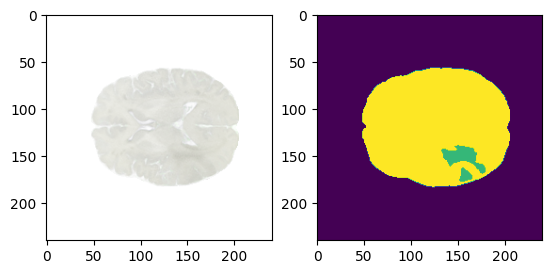

In [17]:
vnum = 7
fig, ax = plt.subplots(1,2)
ax[0].imshow(tf.cast(127.5*(val_images[vnum]+1), 'uint8'))
ax[1].imshow(val_masks[vnum])

In [ ]:
np.unique(sample_mask, return_counts=True)

In [20]:
# Calculate class weights
weights = 1.0/np.array(pixel_counts)
weights = weights/np.sum(weights)

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  #class_weights = tf.constant([2.0, 2.0, 1.0])
  #class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [29]:
# Define convolution layer steps
initializer = tf.random_normal_initializer(0., 0.02)

def horizontal_convolution(input, num_filters, dropout_rate=0.0):
    
    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        padding= 'same',
        strides=1,
        kernel_initializer=initializer,
        use_bias=False,
    )(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x) 
    return x


def down_step(input, num_filters, dropout_rate=0.0):
    x = horizontal_convolution(
        input=input,
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    horizontal_out = horizontal_convolution(
        x, 
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    down_out = tf.keras.layers.MaxPooling2D(
        pool_size=2,
        strides=2, 
        padding = 'same'
    )(horizontal_out)
    return down_out, horizontal_out


def up_step(
    up_input, 
    horizontal_input, 
    num_filters, 
    dropout_rate=0.0, 
):
    x = tf.keras.layers.Conv2DTranspose(
        filters=num_filters,
        kernel_size=3, 
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False,
    )(up_input)
    x = tf.keras.layers.Concatenate()([x, horizontal_input])
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    return x

In [30]:
# Define U-Net topology
def unet(input_shape, output_channels, scale_filters=1.0):
    inputs = tf.keras.layers.Input(shape=input_shape)

    down_1, cross_1 = down_step(inputs, int(64*scale_filters))  # 240 -> 120
    down_2, cross_2 = down_step(down_1, int(128*scale_filters))  # 120 -> 60
    down_3, cross_3 = down_step(down_2, int(256*scale_filters))  # 60 -> 30
    down_4, cross_4 = down_step(down_3, int(512*scale_filters))  # 30 -> 15

    bottom = horizontal_convolution(down_4, int(1024*scale_filters))

    up_4 = up_step(bottom, cross_4, int(512*scale_filters))  # 15 -> 30
    up_3 = up_step(up_4, cross_3, int(256*scale_filters))  # 30 -> 60
    up_2 = up_step(up_3, cross_2, int(128*scale_filters))  # 60 -> 120
    up_1 = up_step(up_2, cross_1, int(64*scale_filters))  # 120 -> 240
    
    outputs = horizontal_convolution(up_1, output_channels)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [42]:
with strategy.scope():
    input_shape = (img_width,img_height,scan_channels)
    model = unet(input_shape=input_shape, output_channels=output_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

2022-12-03 15:18:23.938343: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-03 15:18:24.005632: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 240, 240, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 240, 240, 64  2304        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 240, 240, 64  256        ['conv2d_39[0][0]']              
 ormalization)                  )                                                           

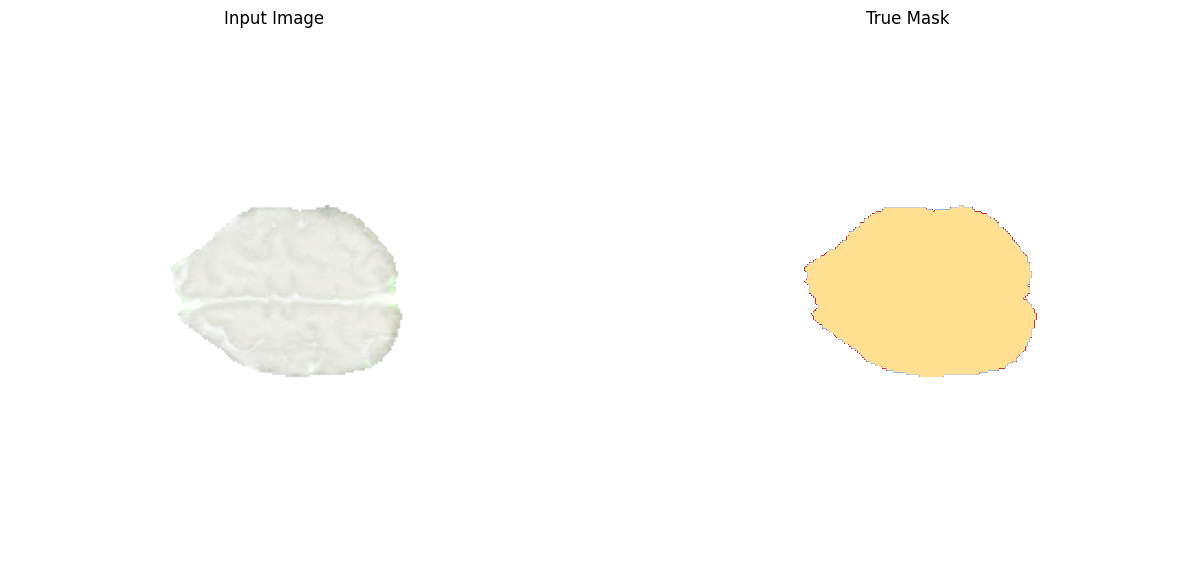

(128, 240, 240, 4) (128, 240, 240, 1)


2022-12-03 15:08:07.812700: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [18]:
for images, masks in train_batch.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])
    print(images.shape, masks.shape)

2022-12-03 15:19:15.327359: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:8186806201560468448
2022-12-03 15:19:15.388819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-03 15:19:15.500756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-03 15:19:15.671963: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(13845706414058689792), session_name()


1/1 [==============================] - 10s 10s/step


2022-12-03 15:19:23.891029: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 13845706414058689792 with session name  took 8.2189832s and succeeded
2022-12-03 15:19:23.899280: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(13845706414058689792), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_8186806201560468448", property.function_library_fingerprint = 14437853042101685733, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-03 15:19:23.899323: I tensorflow/cor

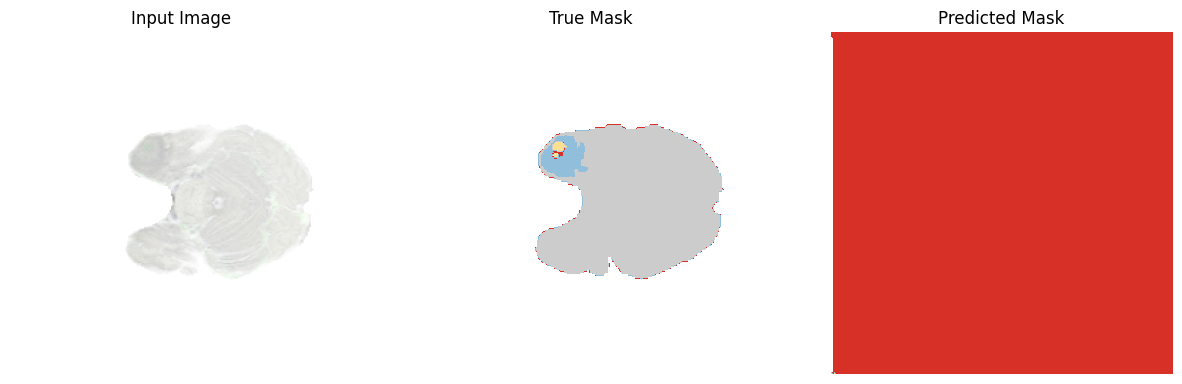

In [44]:
slice_num=17
sample_image, sample_mask = images[slice_num], masks[slice_num]
show_predictions()

In [45]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [46]:
earlystopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            )

In [47]:
print(len(train_image_filepaths),len(val_image_filepaths))

61772 15443


2022-12-03 15:19:41.708690: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 61772
  }
}
attr {
  key: "is_files"
  value {
    b: true
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/40


2022-12-03 15:19:51.204627: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:12094855005085935913
2022-12-03 15:19:51.581956: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-03 15:19:51.876359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-03 15:19:53.525943: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(13134331095159516645), session_name()
2022-12-03 15:21:06.491246: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 13134331095159516645 with session name  took 1m12.965163423s and succeeded
2022-12-03 15:21:06.526274: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU h

482/482 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.7556

2022-12-03 15:25:05.009413: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 15443
  }
}
attr {
  key: "is_files"
  value {
    b: true
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:3"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-12-03 

1/1 [==============================] - 0s 472ms/step


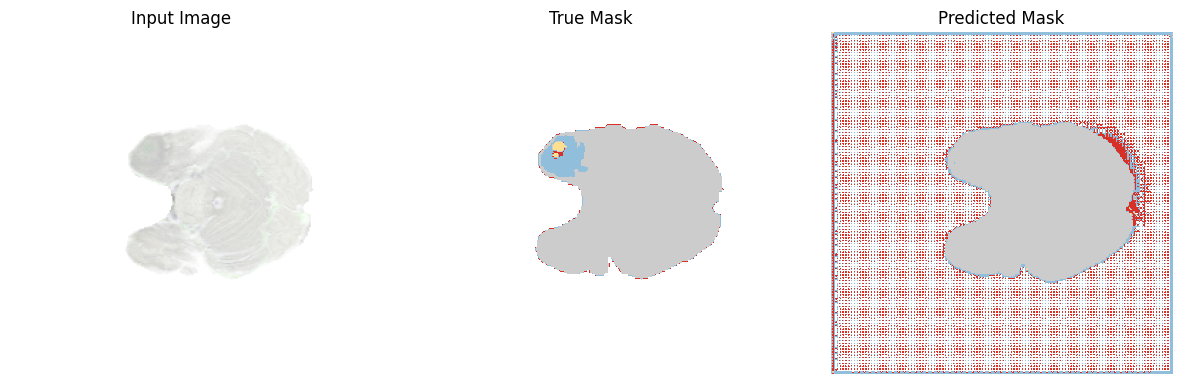


Sample Prediction after epoch 1

482/482 [==============================] - 384s 623ms/step - loss: 0.0022 - accuracy: 0.7556 - val_loss: 1.1525 - val_accuracy: 0.7416
Epoch 2/40
1/1 [==============================] - 0s 442ms/step loss: 0.0017 - accuracy: 0.86


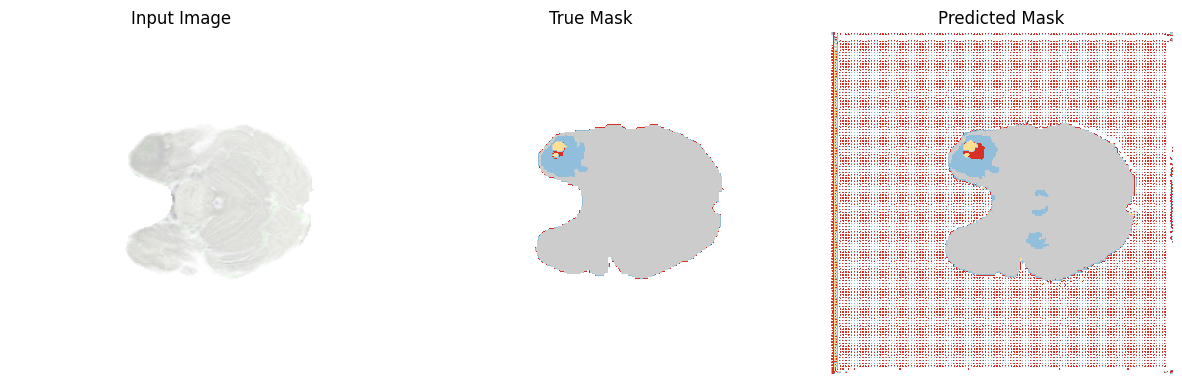


Sample Prediction after epoch 2

482/482 [==============================] - 243s 505ms/step - loss: 0.0017 - accuracy: 0.8641 - val_loss: 1.0437 - val_accuracy: 0.7836
Epoch 3/40
1/1 [==============================] - 0s 452ms/step loss: 0.0015 - accuracy: 0.89


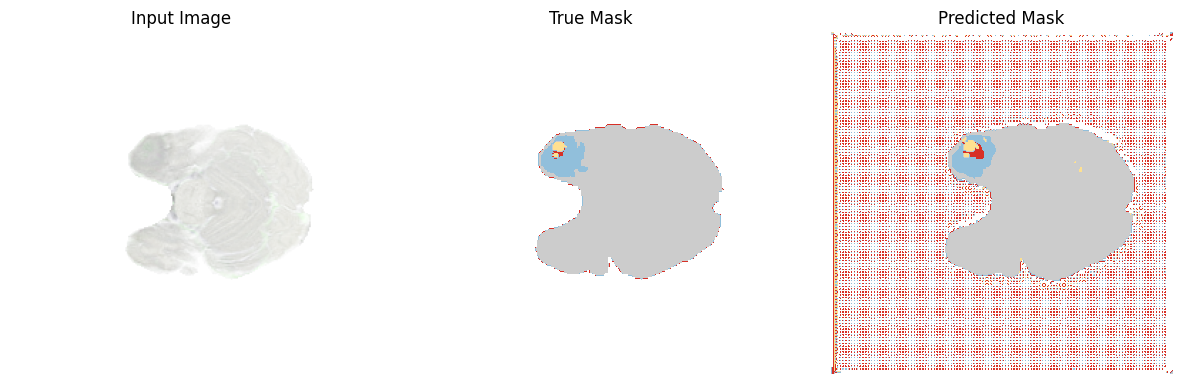


Sample Prediction after epoch 3

482/482 [==============================] - 244s 505ms/step - loss: 0.0015 - accuracy: 0.8913 - val_loss: 1.0131 - val_accuracy: 0.7960
Epoch 4/40
1/1 [==============================] - 0s 449ms/step loss: 0.0014 - accuracy: 0.89


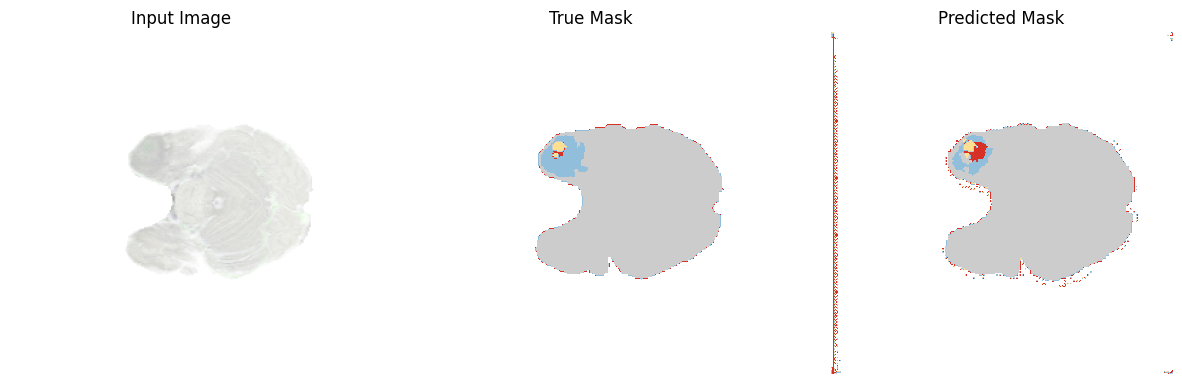


Sample Prediction after epoch 4

482/482 [==============================] - 243s 504ms/step - loss: 0.0014 - accuracy: 0.8936 - val_loss: 0.9181 - val_accuracy: 0.9789
Epoch 5/40
1/1 [==============================] - 0s 438ms/step loss: 0.0013 - accuracy: 0.88


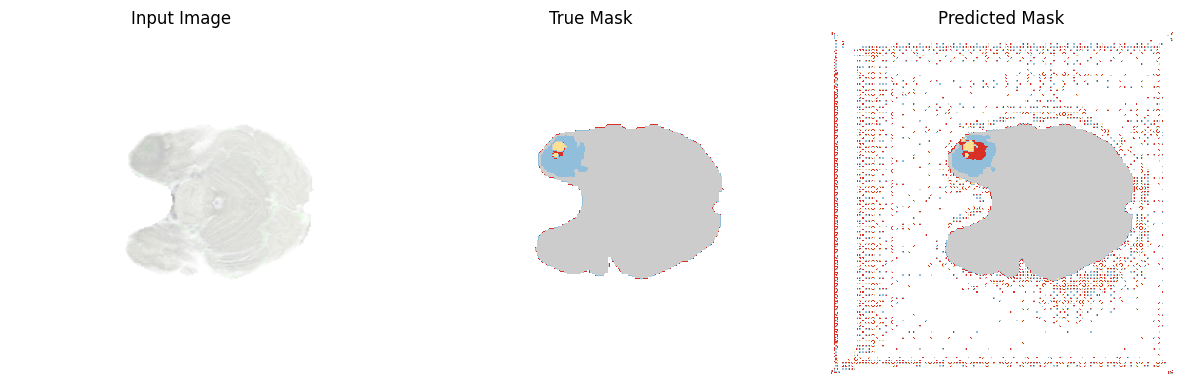


Sample Prediction after epoch 5

482/482 [==============================] - 242s 501ms/step - loss: 0.0013 - accuracy: 0.8808 - val_loss: 0.8785 - val_accuracy: 0.9433
Epoch 6/40
1/1 [==============================] - 0s 450ms/step loss: 0.0012 - accuracy: 0.92


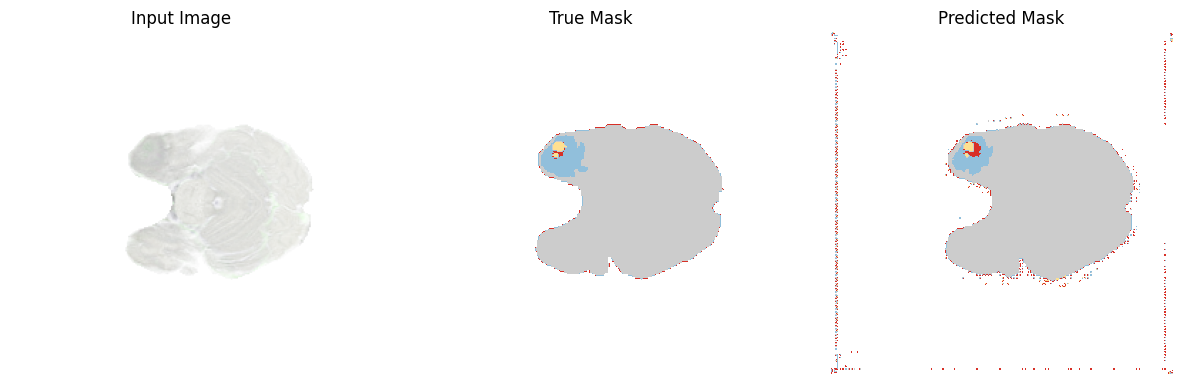


Sample Prediction after epoch 6

482/482 [==============================] - 243s 505ms/step - loss: 0.0012 - accuracy: 0.9208 - val_loss: 0.8289 - val_accuracy: 0.9856
Epoch 7/40
1/1 [==============================] - 0s 451ms/step loss: 0.0012 - accuracy: 0.95


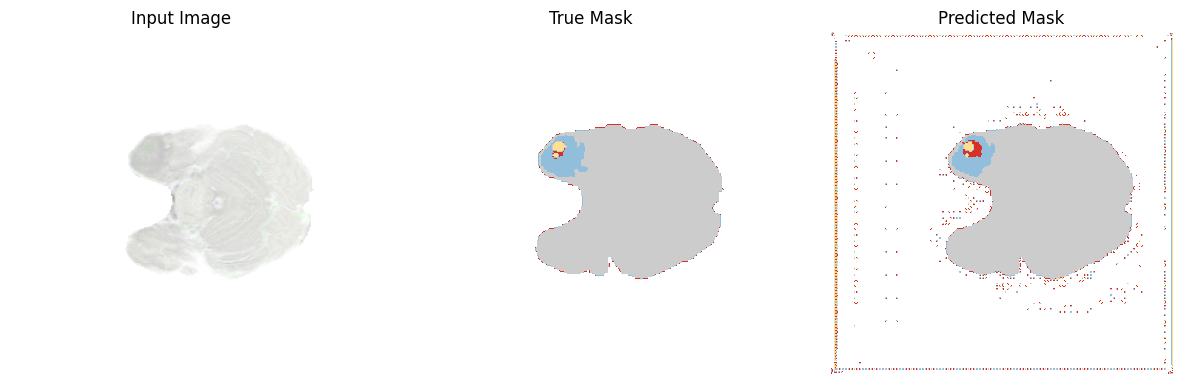


Sample Prediction after epoch 7

482/482 [==============================] - 242s 503ms/step - loss: 0.0012 - accuracy: 0.9510 - val_loss: 0.7920 - val_accuracy: 0.9714
Epoch 8/40
1/1 [==============================] - 0s 442ms/step loss: 0.0011 - accuracy: 0.96


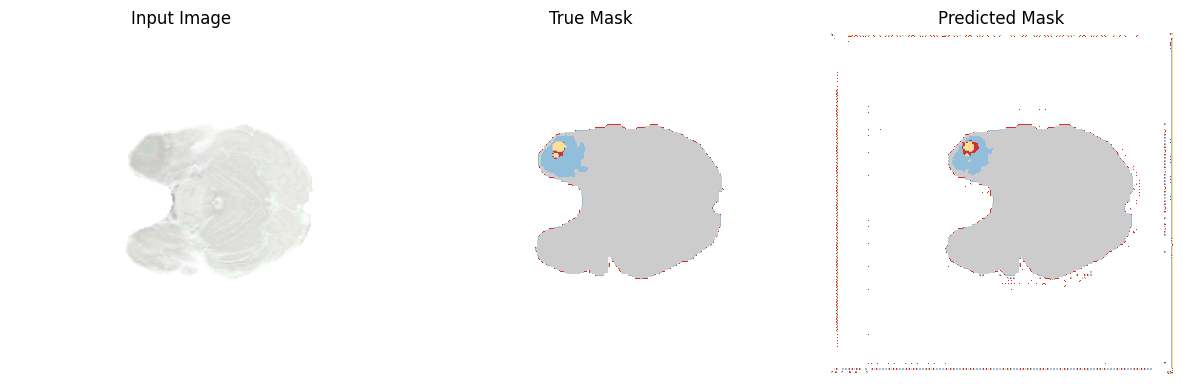


Sample Prediction after epoch 8

482/482 [==============================] - 243s 504ms/step - loss: 0.0011 - accuracy: 0.9645 - val_loss: 0.7464 - val_accuracy: 0.9843
Epoch 9/40
1/1 [==============================] - 0s 449ms/step loss: 0.0010 - accuracy: 0.97


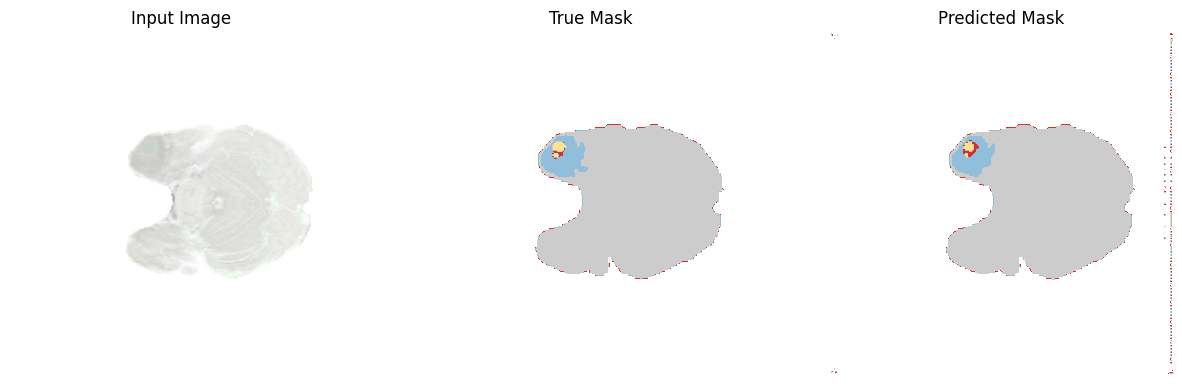


Sample Prediction after epoch 9

482/482 [==============================] - 243s 503ms/step - loss: 0.0010 - accuracy: 0.9711 - val_loss: 0.6886 - val_accuracy: 0.9952
Epoch 10/40
1/1 [==============================] - 0s 447ms/step loss: 9.8641e-04 - accuracy: 0.97


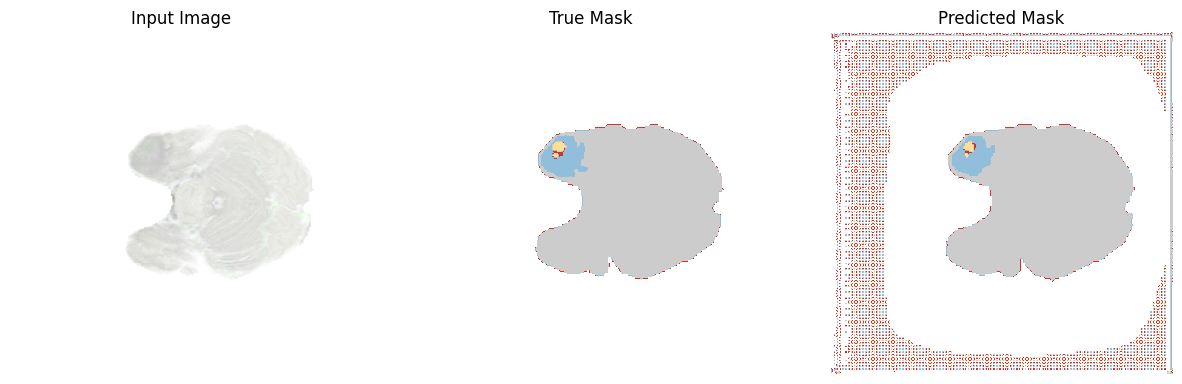


Sample Prediction after epoch 10

482/482 [==============================] - 241s 500ms/step - loss: 9.8641e-04 - accuracy: 0.9744 - val_loss: 0.7166 - val_accuracy: 0.9194
Epoch 11/40
1/1 [==============================] - 0s 452ms/step loss: 9.2260e-04 - accuracy: 0.98


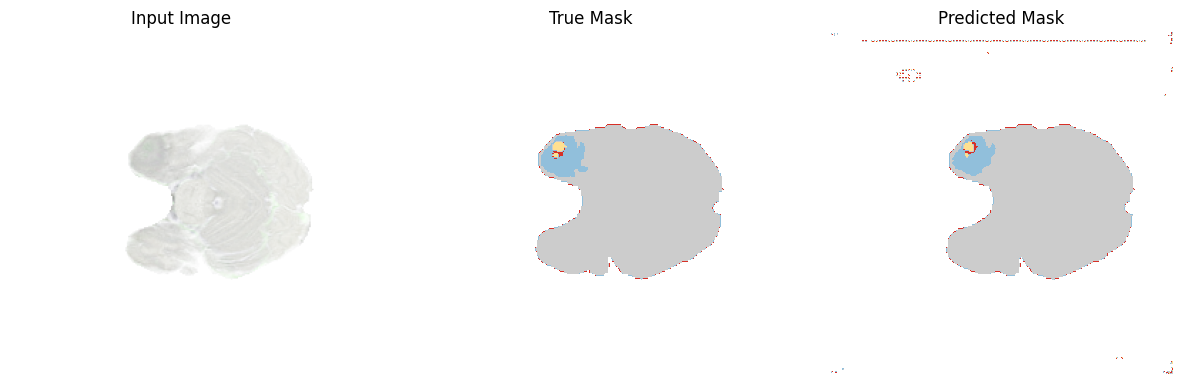


Sample Prediction after epoch 11

482/482 [==============================] - 242s 503ms/step - loss: 9.2260e-04 - accuracy: 0.9856 - val_loss: 0.7693 - val_accuracy: 0.9943
Epoch 12/40
1/1 [==============================] - 0s 451ms/step loss: 8.6893e-04 - accuracy: 0.98


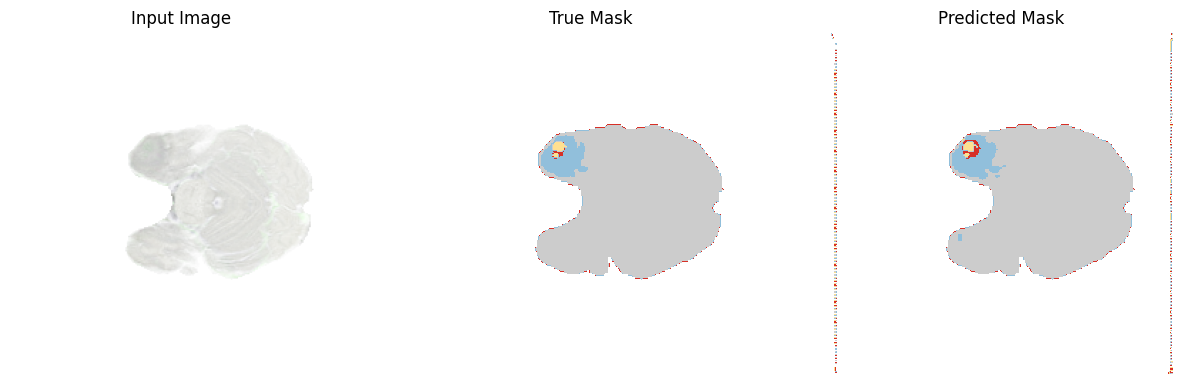


Sample Prediction after epoch 12

482/482 [==============================] - 244s 505ms/step - loss: 8.6893e-04 - accuracy: 0.9884 - val_loss: 0.5423 - val_accuracy: 0.9921
Epoch 13/40
1/1 [==============================] - 0s 450ms/step loss: 8.2318e-04 - accuracy: 0.98


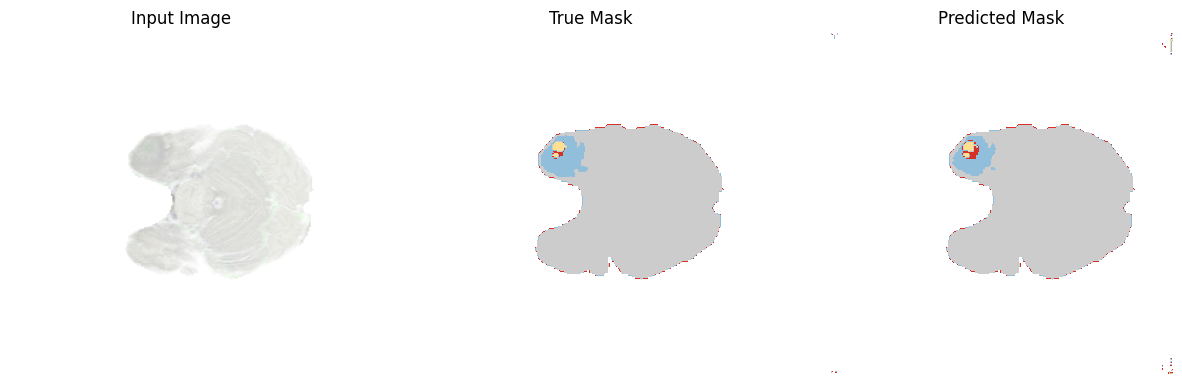


Sample Prediction after epoch 13

482/482 [==============================] - 243s 505ms/step - loss: 8.2318e-04 - accuracy: 0.9889 - val_loss: 0.6081 - val_accuracy: 0.9977
Epoch 14/40
1/1 [==============================] - 0s 442ms/step loss: 7.8216e-04 - accuracy: 0.98


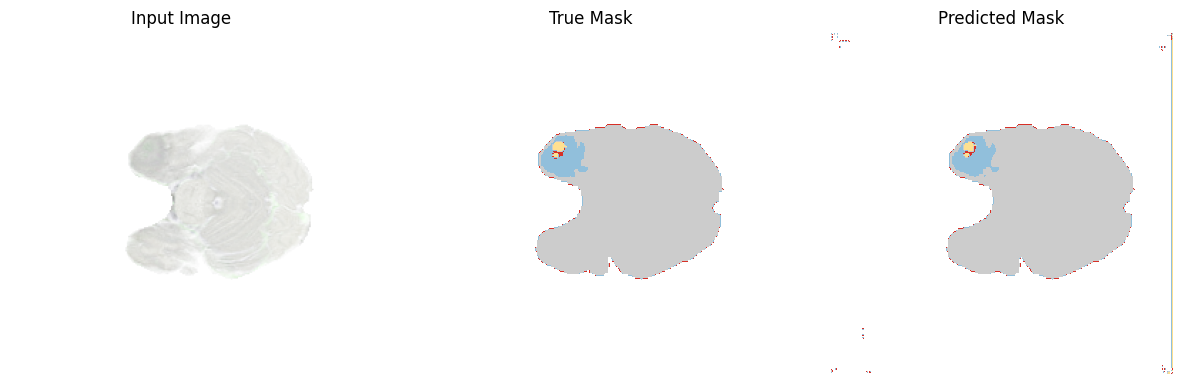


Sample Prediction after epoch 14

482/482 [==============================] - 242s 502ms/step - loss: 7.8216e-04 - accuracy: 0.9893 - val_loss: 0.6681 - val_accuracy: 0.9937
Epoch 15/40
1/1 [==============================] - 0s 442ms/step loss: 7.4912e-04 - accuracy: 0.98


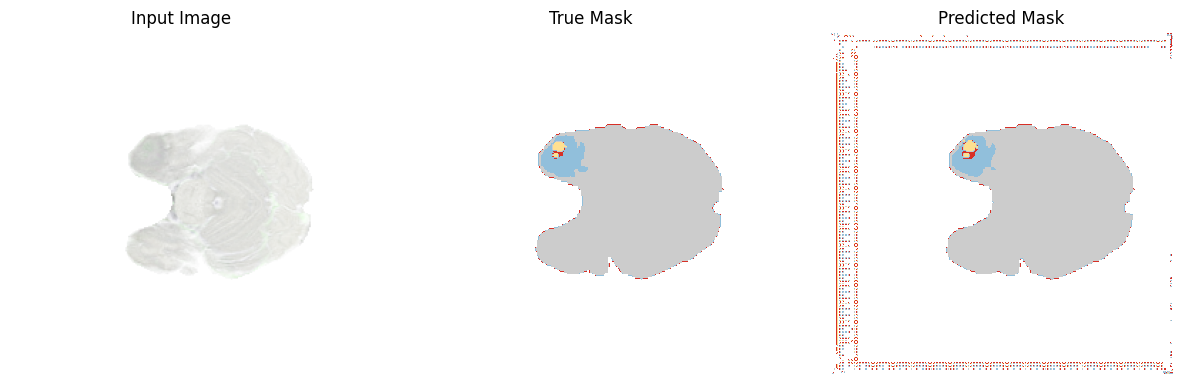


Sample Prediction after epoch 15

482/482 [==============================] - 242s 501ms/step - loss: 7.4912e-04 - accuracy: 0.9893 - val_loss: 0.5596 - val_accuracy: 0.9745


In [48]:
#lr 0.0001
TRAIN_LENGTH=61772
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 15443//batch_size//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // batch_size

model_history = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

In [49]:
val_images, val_maps = next(iter(val_batch[0].take(1)))

In [50]:
type(val_maps)

tensorflow.python.framework.ops.EagerTensor

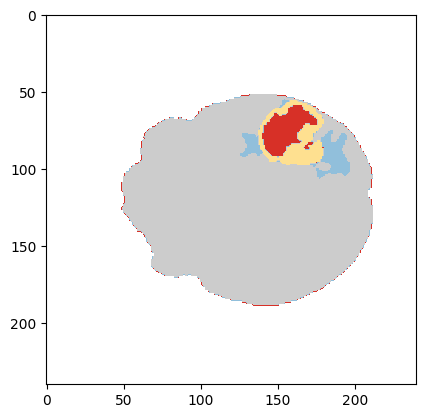

In [83]:
#val_maps.shape
num = 13
plt.imshow(tf.cast(val_maps[num,:,:,0],'uint8'), cmap=cmap)

In [84]:
single_img = tf.expand_dims(val_images[num],0)
single_map = tf.expand_dims(val_maps[num],0)


In [85]:
single_ds = tf.data.Dataset.from_tensor_slices(([single_img],[single_map]))


1/1 [==============================] - 0s 460ms/step


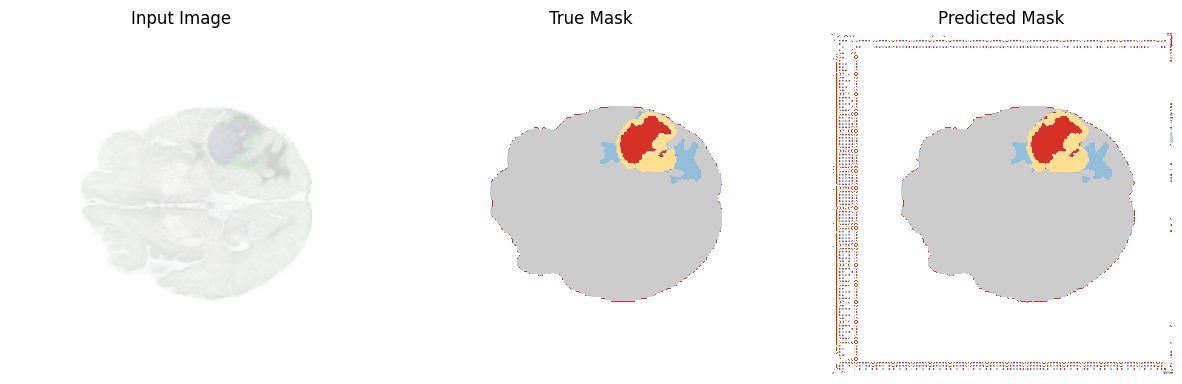

In [86]:
show_predictions(single_ds)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            )

In [ ]:
# Train layers below layer 100 in down branch
model.layers[4].trainable = True
for layer in model.layers[4].layers[:100]:
    layer.trainable = False


In [ ]:
with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [ ]:
model_history_partialrelax = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=50,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=model_history.epoch[-1]+1,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

In [ ]:
show_predictions(single_ds)

In [ ]:
# Train all layers
model.trainable = True



In [ ]:
with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [ ]:
VALIDATION_STEPS = 15443//batch_size

In [ ]:
model_history_fullrelax = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=80,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=model_history_partialrelax.epoch[-1]+1,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)